## Import packages

In [ ]:
# Import packages
import urllib.request
import json
import zipfile
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import progressbar
from geopy.distance import geodesic
from google.colab import files
import warnings

!pip install simpy --quiet
import simpy
!pip install sympy==1.7 --quiet
import sympy
!pip install pynverse --quiet
import pynverse

# Set configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(suppress=True)
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 12
warnings.filterwarnings("ignore")

     |████████████████████████████████| 5.9MB 5.5MB/s 


## Download Citibike Trips Data

### Trips

In [ ]:
# Define months for which data is to be downloaded
year_month_list = ["202008", "202009", "202010"]
# year_month_list = ["202010"]

# Define directories
directories = ["./zipfiles/", "./data/"]

# Create directories
for dir in directories:
  if not os.path.isdir(dir):
    os.makedirs(dir)

# Download files
for year_month in year_month_list:

  # Create URL
  url = "https://s3.amazonaws.com/tripdata/" + year_month + "-citibike-tripdata.csv.zip"

  # Define file names for zip files
  filename = "./zipfiles/" + year_month + "_citibike_tripdata.csv.zip"

  # Download files
  urllib.request.urlretrieve(url, filename)

  # Unzip files
  with zipfile.ZipFile(filename, 'r') as zip_ref:
      zip_ref.extractall("./data/")

### Station Capacity (Docks)

In [ ]:
# Station capacity URL
station_capacity_url = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"

# Parse JSON
with urllib.request.urlopen(station_capacity_url) as url:
    data = json.loads(url.read().decode())

# Get capacities
station_capacity = dict()
for item in data['data']['stations']:
    station_capacity[int(item['station_id'])] = item['capacity']

# Convert to series
station_capacity = pd.Series(station_capacity)

## Read data

From: https://www.citibikenyc.com/system-data

In [ ]:
# Initialize trips dataframe
trips_data = pd.DataFrame()

# List all downloaded csv files
trip_files = sorted([f for f in os.listdir("./data/") if f.startswith('20')])
print(len(trip_files), "files to read")

# Read each csv file and append
for trips_file in trip_files:

  # Read
  print("Reading file:", trips_file)
  trips = pd.read_csv("./data/" + trips_file)

  # Append
  trips_data = pd.concat([trips_data, trips])
  print("Done")

print("Completed")

3 files to read
Reading file: 202008-citibike-tripdata.csv
Done
Reading file: 202009-citibike-tripdata.csv
Done
Reading file: 202010-citibike-tripdata.csv
Done
Completed


## Data Preparation

In [ ]:
# Fix datatypes
trips_data["starttime"] = pd.to_datetime(trips_data["starttime"], infer_datetime_format=True)
trips_data["stoptime"] = pd.to_datetime(trips_data["stoptime"], infer_datetime_format=True)
trips_data["startdate"] = trips_data["starttime"].dt.date

In [ ]:
# Hour of day for start and stop time
trips_data["start hour"] = trips_data['starttime'].dt.hour
trips_data["stop hour"] = trips_data['stoptime'].dt.hour

In [ ]:
# Bin Start time
start_time_bins = ["12:00am - 2:59am",
                   "3:00am - 5:59am",
                   "6:00am - 8:59am",
                   "9:00am - 11:59am",
                   "12:00pm - 2:59pm",
                   "3:00pm - 5:59pm",
                   "6:00pm - 8:59pm",
                   "9:00pm - 11:59pm"]
trips_data["start time bin"] = pd.cut(trips_data['start hour'], bins=[0, 3, 6, 9, 12, 15, 18, 21, 24], right=False, labels=start_time_bins)

In [ ]:
# Number of unique stations
all_stations = np.unique(np.append(trips_data["start station id"].values, trips_data["end station id"].values))
all_stations.shape

(1186,)

In [ ]:
# Closed stations

# 1. Stations which do not have a capacity
stations_closed = list(set(all_stations).difference(set(station_capacity.index)))

# 2. Stations which have capacity = 0
stations_closed.extend(station_capacity.loc[station_capacity == 0].index)

# Remove closed stations
trips_data = trips_data.loc[~(trips_data["start station id"].isin(stations_closed)) &
                            ~(trips_data["end station id"].isin(stations_closed)), :]

In [ ]:
# Rows and columns
trips_data.shape

(6867174, 19)

In [ ]:
# After removing closed stations: Number of unique stations
all_stations = np.unique(np.append(trips_data["start station id"].values, trips_data["end station id"].values))
station_capacity = station_capacity.loc[all_stations]
all_stations.shape

(1166,)

In [ ]:
n_citibikes = np.unique(trips_data["bikeid"]).shape[0]
n_citibikes

20568

In [ ]:
trips_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,startdate,start hour,stop hour,start time bin
1,7002,2020-08-01 00:00:01.591,2020-08-01 01:56:44.072,3144,E 81 St & Park Ave,40.776777,-73.959010,3671,E 81 St & 2 Ave,40.774779,-73.954275,37191,Subscriber,1966,1,2020-08-01,0,1,12:00am - 2:59am
2,155,2020-08-01 00:00:03.581,2020-08-01 00:02:38.634,387,Centre St & Chambers St,40.712733,-74.004607,387,Centre St & Chambers St,40.712733,-74.004607,42561,Customer,1969,0,2020-08-01,0,0,12:00am - 2:59am
3,2720,2020-08-01 00:00:05.013,2020-08-01 00:45:25.327,3080,S 4 St & Rodney St,40.709340,-73.956080,3364,Carroll St & 5 Ave,40.675162,-73.981483,41607,Subscriber,1990,1,2020-08-01,0,0,12:00am - 2:59am
4,2938,2020-08-01 00:00:05.942,2020-08-01 00:49:03.964,3510,Adam Clayton Powell Blvd & W 123 St,40.807832,-73.949373,3282,5 Ave & E 88 St,40.783070,-73.959390,36366,Customer,1969,0,2020-08-01,0,0,12:00am - 2:59am
5,5708,2020-08-01 00:00:06.467,2020-08-01 01:35:15.080,508,W 46 St & 11 Ave,40.763414,-73.996674,3699,W 50 St & 9 Ave,40.763605,-73.989180,19221,Customer,1969,0,2020-08-01,0,1,12:00am - 2:59am


## Estimating Model Parameters from Data

### Estimating Destination Probabilities

In [ ]:
# For every station and every time bin, count the total number of trips
total_trips_time_bin = trips_data.groupby(["start station id", "start time bin"]).size().to_frame('total_trips_time_bin').reset_index()

# For every station, every time bin, and every destination, count the total number of trips and avg. duration
station_trips_time_bin = trips_data.groupby(["start station id", "start time bin", "end station id"]).size().to_frame('trips_to_station_time_bin').reset_index()

# Join the two dataframes
station_trips_time_bin = station_trips_time_bin.merge(total_trips_time_bin, how="left", left_on=["start station id", "start time bin"], right_on=["start station id", "start time bin"])

station_trips_time_bin.head()

,start station id,start time bin,end station id,trips_to_station_time_bin,total_trips_time_bin
0,72,12:00am - 2:59am,72,4,96
1,72,12:00am - 2:59am,79,0,96
2,72,12:00am - 2:59am,82,0,96
3,72,12:00am - 2:59am,83,0,96
4,72,12:00am - 2:59am,116,0,96


In [ ]:
# Conditioned that a customer arrives at a given station and a time, calculate the probability of a customer for going to a specific station
station_trips_time_bin["station_id_destination_prob"] = station_trips_time_bin["trips_to_station_time_bin"] / station_trips_time_bin["total_trips_time_bin"]

# NA probability is when there are no trips from that station. The probability of going anywhere from that station is 0
station_trips_time_bin["station_id_destination_prob"] = station_trips_time_bin["station_id_destination_prob"].fillna(0)
destination_prob = station_trips_time_bin.drop(columns=["trips_to_station_time_bin", "total_trips_time_bin"])

# Create matrix
destination_prob_matrix = destination_prob.pivot(index=["start station id", "start time bin"], columns="end station id", values="station_id_destination_prob")
destination_prob_matrix.head()

end station id                         72        79        82    83    \
start station id start time bin                                         
72               12:00am - 2:59am  0.041667  0.000000  0.000000   0.0   
                 3:00am - 5:59am   0.090909  0.000000  0.000000   0.0   
                 6:00am - 8:59am   0.056856  0.003344  0.000000   0.0   
                 9:00am - 11:59am  0.031679  0.000000  0.001056   0.0   
                 12:00pm - 2:59pm  0.040643  0.000945  0.000000   0.0   

end station id                         116   119   120       127       128   \
start station id start time bin                                               
72               12:00am - 2:59am  0.000000   0.0   0.0  0.010417  0.000000   
                 3:00am - 5:59am   0.000000   0.0   0.0  0.000000  0.000000   
                 6:00am - 8:59am   0.001672   0.0   0.0  0.000000  0.000000   
                 9:00am - 11:59am  0.004224   0.0   0.0  0.008448  0.003168   
                 12:00pm - 2:59pm  0.000945   0.0   0.0  0.002836  0.000945   

end station id                     143   144       146   150       151   152   \
start station id start time bin                                                 
72               12:00am - 2:59am   0.0   0.0  0.000000   0.0  0.000000   0.0   
                 3:00am - 5:59am    0.0   0.0  0.000000   0.0  0.000000   0.0   
                 6:00am - 8:59am    0.0   0.0  0.000000   0.0  0.030100   0.0   
                 9:00am - 11:59am   0.0   0.0  0.002112   0.0  0.001056   0.0   
                 12:00pm - 2:59pm   0.0   0.0  0.002836   0.0  0.000000   0.0   

end station id                     157       161       164   168       173   \
start station id start time bin                                               
72               12:00am - 2:59am   0.0  0.000000  0.000000   0.0  0.000000   
                 3:00am - 5:59am    0.0  0.000000  0.000000   0.0  0.000000   
                 6:00am - 8:59am    0.0  0.000000  0.000000   0.0  0.001672   
                 9:00am - 11:59am   0.0  0.003168  0.003168   0.0  0.001056   
                 12:00pm - 2:59pm   0.0  0.000945  0.000945   0.0  0.004726   

end station id                         174       212   216   217       223   \
start station id start time bin                                               
72               12:00am - 2:59am  0.000000  0.020833   0.0   0.0  0.000000   
                 3:00am - 5:59am   0.000000  0.000000   0.0   0.0  0.000000   
                 6:00am - 8:59am   0.001672  0.015050   0.0   0.0  0.000000   
                 9:00am - 11:59am  0.000000  0.004224   0.0   0.0  0.002112   
                 12:00pm - 2:59pm  0.000000  0.010397   0.0   0.0  0.002836   

end station id                         224       228   229       236   237   \
start station id start time bin                                               
72               12:00am - 2:59am  0.000000  0.000000   0.0  0.010417   0.0   
                 3:00am - 5:59am   0.000000  0.000000   0.0  0.000000   0.0   
                 6:00am - 8:59am   0.000000  0.001672   0.0  0.000000   0.0   
                 9:00am - 11:59am  0.001056  0.004224   0.0  0.002112   0.0   
                 12:00pm - 2:59pm  0.000945  0.000000   0.0  0.001890   0.0   

end station id                         238   239   241   242   244   245   \
start station id start time bin                                             
72               12:00am - 2:59am  0.000000   0.0   0.0   0.0   0.0   0.0   
                 3:00am - 5:59am   0.000000   0.0   0.0   0.0   0.0   0.0   
                 6:00am - 8:59am   0.005017   0.0   0.0   0.0   0.0   0.0   
                 9:00am - 11:59am  0.008448   0.0   0.0   0.0   0.0   0.0   
                 12:00pm - 2:59pm  0.007561   0.0   0.0   0.0   0.0   0.0   

end station id                         247       248      249       250   \
start station id start time bin                                            
72          

### Estimating Arrival Process Parameters

In [ ]:
# Get total number of arrivals
n_arrivals_time_bin = trips_data.groupby(["start station id", "start time bin"]).size().to_frame("total_arrivals").reset_index()

# Number of days in the data
n_days = (trips_data["startdate"].max() - trips_data["startdate"].min()).days + 1

# Calculate mean arrivals
n_arrivals_time_bin["lmbdas"] = n_arrivals_time_bin["total_arrivals"] / n_days / 3 / 60 / 60

# Create lambda matrix
lmbda_matrix = n_arrivals_time_bin.pivot(index="start station id", columns="start time bin", values="lmbdas")

lmbda_matrix.head()

start time bin,12:00am - 2:59am,3:00am - 5:59am,6:00am - 8:59am,9:00am - 11:59am,12:00pm - 2:59pm,3:00pm - 5:59pm,6:00pm - 8:59pm,9:00pm - 11:59pm
start station id,,,,,,,,
72,0.000097,0.000089,0.000602,0.000953,0.001065,0.001485,0.001199,0.000275
79,0.000189,0.000038,0.000448,0.000903,0.001417,0.001981,0.001545,0.000705
82,0.000061,0.000041,0.000358,0.000550,0.000849,0.000933,0.000961,0.000236
83,0.000105,0.000021,0.000338,0.000656,0.001325,0.001548,0.001494,0.000575
116,0.000378,0.000122,0.001690,0.002198,0.003325,0.003965,0.003583,0.001336


In [ ]:
# Fill missing stations, if any (Enforcing shape to be #unique stations * #columns)
row_missing_stations = list(set(all_stations).difference(set(lmbda_matrix.index)))
for i in row_missing_stations:
  lmbda_matrix.loc[i, :] = np.nan

# Fill NA with zeros (no arrival)
lmbda_matrix = lmbda_matrix.fillna(0)
lmbda_matrix = lmbda_matrix.replace(np.inf, 0)

# Assume that the actual arrival rate is 5% higher than recorded arrivals
lmbda_matrix = lmbda_matrix * 1.05

lmbda_matrix.head()

start time bin,12:00am - 2:59am,3:00am - 5:59am,6:00am - 8:59am,9:00am - 11:59am,12:00pm - 2:59pm,3:00pm - 5:59pm,6:00pm - 8:59pm,9:00pm - 11:59pm
start station id,,,,,,,,
72,0.000101,0.000093,0.000632,0.001001,0.001118,0.001559,0.001259,0.000288
79,0.000199,0.000040,0.000470,0.000948,0.001488,0.002080,0.001622,0.000740
82,0.000064,0.000043,0.000376,0.000577,0.000892,0.000980,0.001009,0.000247
83,0.000110,0.000022,0.000355,0.000689,0.001392,0.001625,0.001568,0.000603
116,0.000397,0.000128,0.001774,0.002308,0.003492,0.004164,0.003762,0.001402


#### Plot to compare sample an theory

224
12:00am - 2:59am


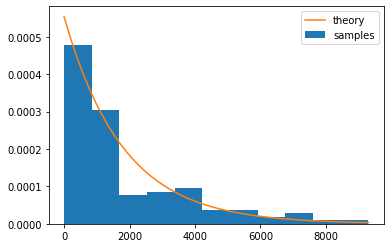

224
3:00am - 5:59am


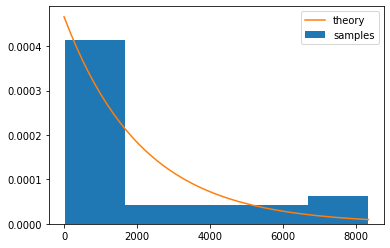

224
6:00am - 8:59am


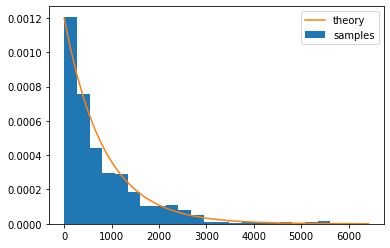

224
9:00am - 11:59am


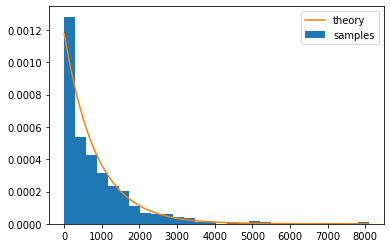

224
12:00pm - 2:59pm


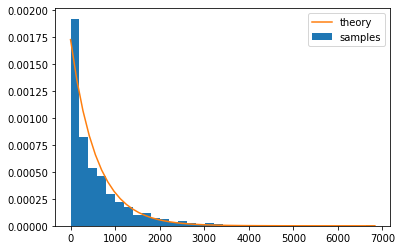

224
3:00pm - 5:59pm


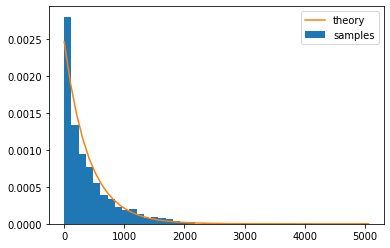

224
6:00pm - 8:59pm


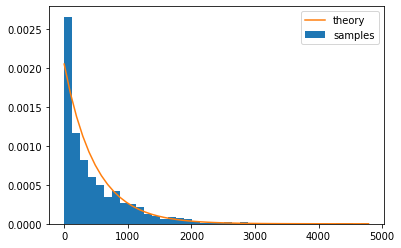

224
9:00pm - 11:59pm


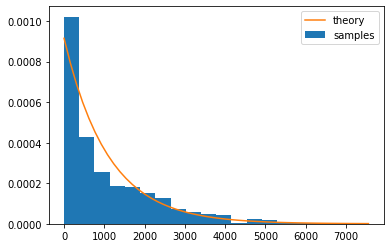

3161
12:00am - 2:59am


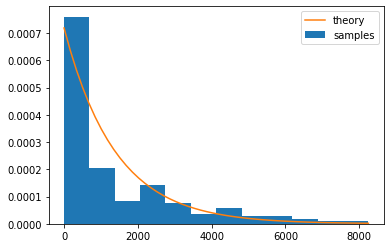

3161
3:00am - 5:59am


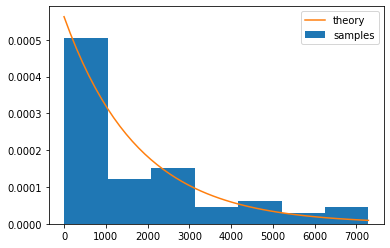

3161
6:00am - 8:59am


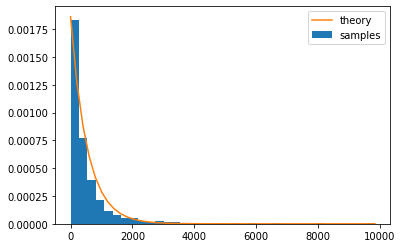

3161
9:00am - 11:59am


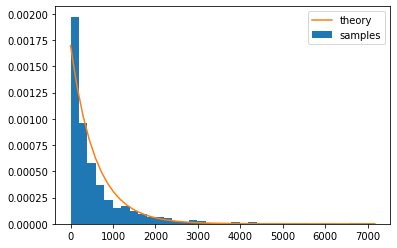

3161
12:00pm - 2:59pm


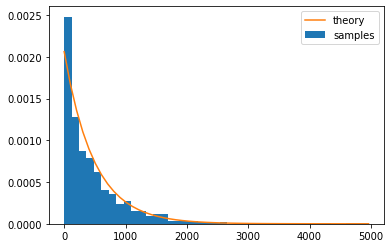

3161
3:00pm - 5:59pm


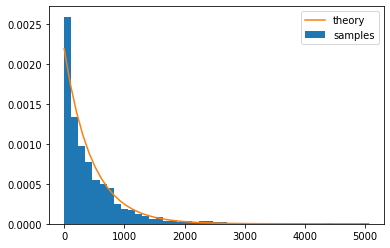

3161
6:00pm - 8:59pm


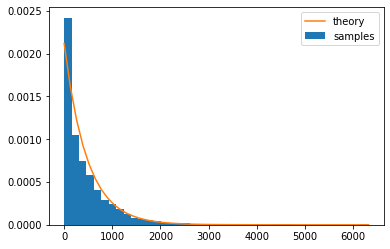

3161
9:00pm - 11:59pm


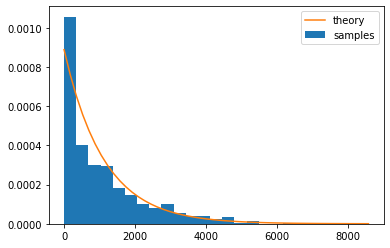

354
12:00am - 2:59am


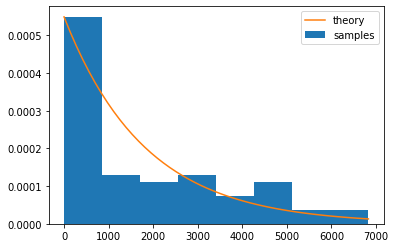

354
3:00am - 5:59am


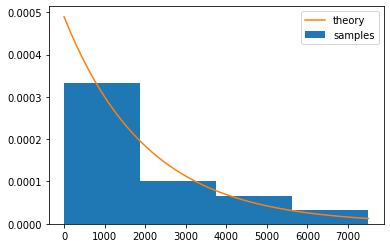

354
6:00am - 8:59am


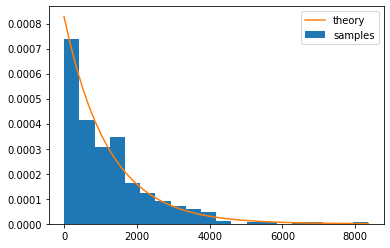

354
9:00am - 11:59am


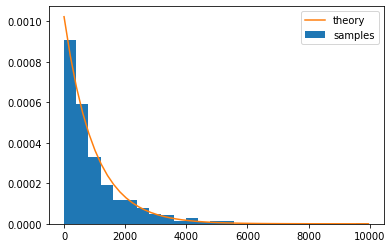

354
12:00pm - 2:59pm


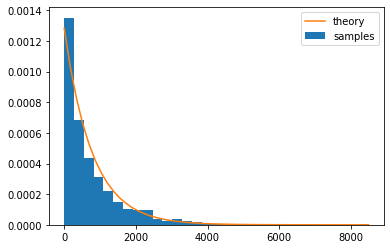

354
3:00pm - 5:59pm


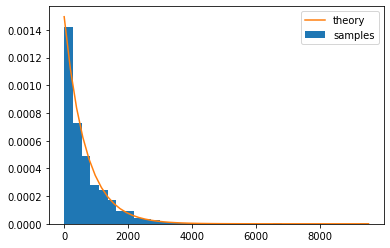

354
6:00pm - 8:59pm


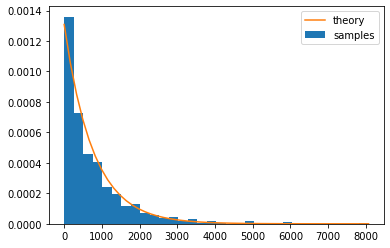

354
9:00pm - 11:59pm


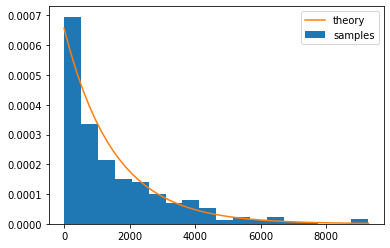

3141
12:00am - 2:59am


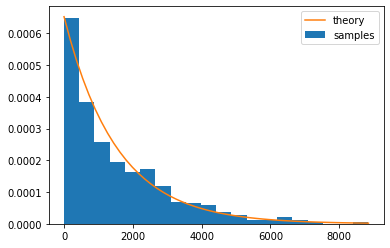

3141
3:00am - 5:59am


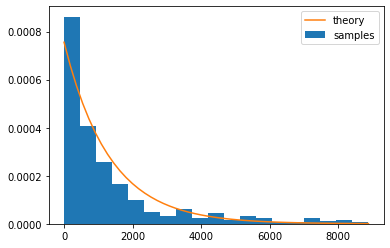

3141
6:00am - 8:59am


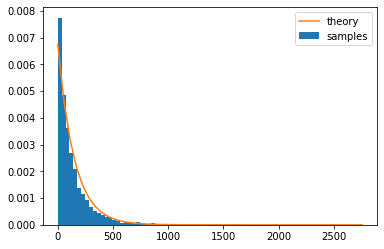

3141
9:00am - 11:59am


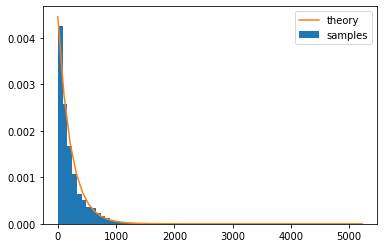

3141
12:00pm - 2:59pm


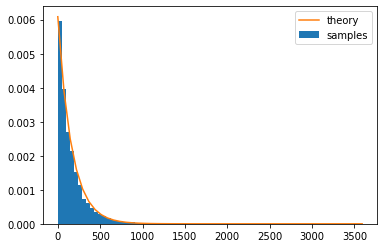

3141
3:00pm - 5:59pm


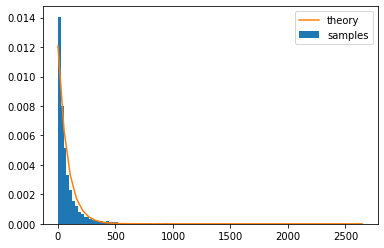

3141
6:00pm - 8:59pm


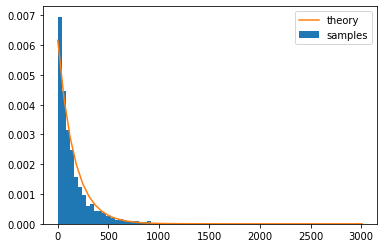

3141
9:00pm - 11:59pm


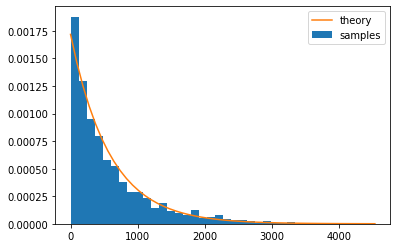

335
12:00am - 2:59am


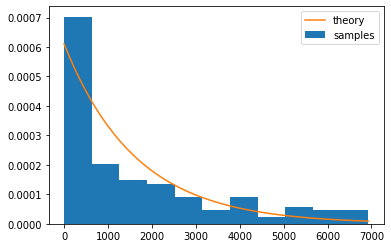

335
3:00am - 5:59am


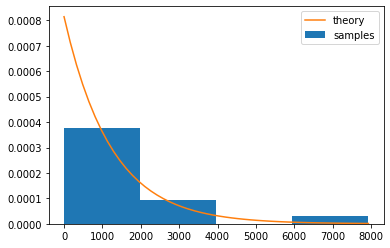

335
6:00am - 8:59am


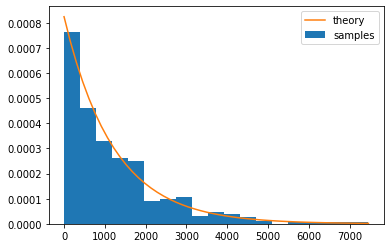

335
9:00am - 11:59am


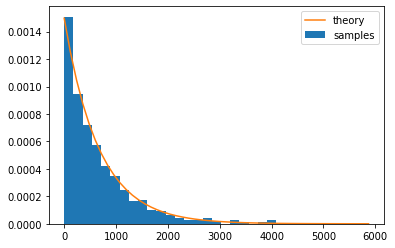

335
12:00pm - 2:59pm


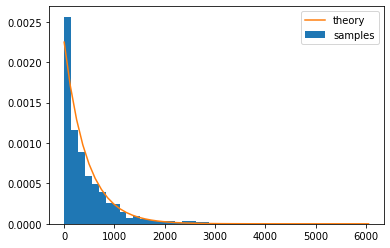

335
3:00pm - 5:59pm


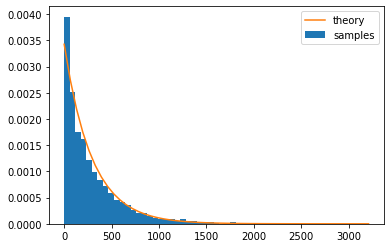

335
6:00pm - 8:59pm


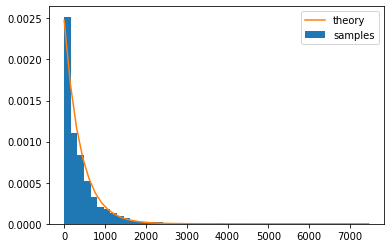

335
9:00pm - 11:59pm


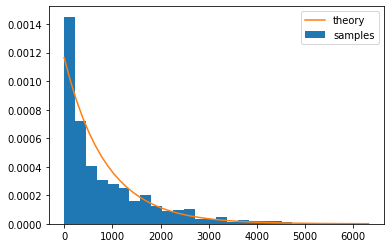

In [ ]:
# Compare samples and theory for a few stations
station_ids = [224, 3161, 354, 3141, 335]

# Sort the data to calculate time difference of arrival
trips_data = trips_data.sort_values(by=["start station id", "start time bin", "startdate", "starttime"])

# Group by station, time bin and start date and calculate time difference of arrival
trips_data["inter_arrival"] = trips_data.groupby(["start station id", "start time bin", "startdate"])["starttime"].diff().dt.seconds

for station_id in station_ids:
  for start_time_bin in start_time_bins:
    print(station_id)
    print(start_time_bin)
    lmbda = lmbda_matrix.loc[station_id, start_time_bin]
    inter_arrivals = trips_data.loc[(trips_data["start station id"] == station_id) &
                                    (trips_data["start time bin"] == start_time_bin), "inter_arrival"].dropna().values

    plt.hist(inter_arrivals, bins=int(inter_arrivals.shape[0]**0.5), density=True, label="samples")
    x = np.linspace(0, np.max(inter_arrivals))
    mean_ = np.mean(inter_arrivals)
    lmbda = 1 / mean_
    pdf = lmbda * np.exp(-lmbda * x)
    plt.plot(x, pdf, label="theory", zorder=2)
    plt.legend(loc="best")
    plt.show()

### Estimating distance between each station pair

In [ ]:
def get_distance(slat, slon, dlat, dlon):

  """
  Returns the geographical distance between source and destination in miles.
  Used for finding the nearest station when a dock is not available
  """

  return geodesic((slat, slon), (dlat, dlon)).miles

# Vectorize for faster numpy operations
vget_distance = np.vectorize(get_distance)

In [ ]:
def create_geo_dist_matrix(station_lat_lon):

  """Create a square matrix for distance between every station combination"""

  # Get list of stations
  stationids = np.unique(station_lat_lon.index)

  # Initialize the distance matrix
  geo_dist_matrix = pd.DataFrame(index=stationids, columns=stationids)

  # Create distance for each source and destination combination
  for source in stationids:

    # Get latitude and longitude
    source_lat = station_lat_lon.loc[source, "lat"]
    source_lon = station_lat_lon.loc[source, "lon"]
    destination_lats = station_lat_lon["lat"].values
    destination_lons = station_lat_lon["lon"].values

    # Calculate distance
    geo_dist_matrix.loc[source, :] = vget_distance(source_lat, source_lon, destination_lats, destination_lons)

  return geo_dist_matrix

In [ ]:
# Get Latitude and Longitude of start stations
start_station_lat_lon = trips_data[["start station id", "start station latitude", "start station longitude"]].drop_duplicates(subset="start station id")
start_station_lat_lon.columns = ["stationid", "lat", "lon"]

# Get Latitude and Longitude of end stations
end_station_lat_lon = trips_data[["end station id", "end station latitude", "end station longitude"]].drop_duplicates(subset="end station id")
end_station_lat_lon.columns = ["stationid", "lat", "lon"]

# Append and drop duplicates by station
station_lat_lon = pd.concat([start_station_lat_lon, end_station_lat_lon]).drop_duplicates(subset="stationid").set_index("stationid")

# Create geographical distance matrix
geo_dist_matrix = create_geo_dist_matrix(station_lat_lon)
geo_dist_matrix.head()

,72,79,82,83,116,119,120,127,128,143,144,146,150,151,152,157,161,164,168,173,174,212,216,217,223,224,228,229,236,237,238,239,241,242,244,245,247,248,249,250,251,252,254,257,258,259,260,261,262,264,265,267,268,270,274,275,276,278,281,282,284,285,289,291,293,295,297,298,301,302,303,304,305,307,308,309,310,311,312,313,315,316,319,320,321,323,324,325,326,327,328,330,331,332,334,335,336,340,341,342,343,344,346,347,349,350,351,353,354,355,356,358,359,360,361,362,363,364,366,367,368,369,372,373,376,377,379,380,383,385,386,387,388,389,390,391,392,393,394,396,397,398,399,400,401,402,403,405,406,408,410,411,412,415,416,417,418,419,420,421,422,423,426,427,432,434,435,436,437,438,439,440,442,443,445,446,447,448,450,453,454,455,456,458,460,461,462,464,465,466,467,468,469,470,471,472,473,474,476,477,478,479,480,481,482,483,484,485,486,487,489,490,492,494,495,496,497,499,500,501,502,503,504,505,507,508,509,510,513,514,515,516,517,519,522,525,526,528,529,530,531,532,533,534,536,539,540,545,546,2000,2002,2003,2005,2006,2008,2009,2010,2012,2017,2021,2022,3016,3041,3042,3043,3044,3046,3047,3048,3049,3050,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072,3074,3075,3076,3077,3078,3080,3081,3082,3083,3085,3086,3087,3088,3092,3093,3094,3095,3096,3100,3101,3102,3105,3106,3107,3108,3109,3110,3112,3113,3115,3116,3117,3118,3119,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3134,3135,3136,3137,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3150,3151,3152,3154,3156,3157,3158,3159,3160,3161,3163,3164,3165,3166,3167,3169,3170,3171,3172,3173,3175,3177,3178,3179,3184,3185,3186,3192,3195,3196,3198,3199,3202,3203,3206,3211,3213,3214,3221,3226,3231,3232,3233,3235,3236,3241,3242,3243,3244,3246,3249,3255,3256,3259,3260,3263,3270,3273,3275,3276,3278,3280,3282,3283,3284,3285,3286,3287,3288,3289,3290,3292,3293,3294,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3317,3318,3319,3321,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3335,3336,3337,3338,3339,3340,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3354,3355,3356,3357,3358,3359,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3372,3373,3374,3375,3376,3377,3378,3379,3381,3382,3383,3384,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399,3400,3402,3403,3404,3405,3407,3408,3409,3410,3411,3412,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3424,3425,3429,3430,3435,3436,3437,3440,3443,3452,3453,3454,3456,3457,3461,3462,3463,3467,3469,3472,3477,3478,3481,3483,3486,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3513,3514,3515,3516,3517,3518,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3549,3551,3552,3553,3554,3555,3557,3558,3559,3561,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3595,3596,3597,3598,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3628,3629,3630,3635,3637,3638,3639,3641,3646,3647,3648,3649,3654,3656,3658,3661,3664,3668,3671,3673,3674,3676,3677,3679,3680,3681,3686,3687,3689,3690,3691,3693,3697,3699,3704,3707,3708,3709,3711,3712,3714,3715,3716,3718,3721,3723,3724,3725,3726,3727,3728,3731,3733,3734,3735,3737,3738,3739,3740,3744,3745,3746,3749,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,3785,3786,3787,3789,3790,3791,3792,3795,3798,3799,3803,3804,3808,3809,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,38

### Estimating travel time parameters between each station pair

#### Estimating mean

In [ ]:
# Calculate average time for each station combination
avg_time = trips_data.groupby(["start station id", "end station id"]).agg({"tripduration": "mean"}).reset_index()
avg_time.columns = ["start station id", "end station id", "tripduration_mean"]
avg_time_matrix = avg_time.pivot(index="start station id", columns="end station id", values="tripduration_mean")

In [ ]:
# Fill missing stations, if any (Enforcing shape to be #unique stations * #unique stations)
row_missing_stations = list(set(all_stations).difference(set(avg_time_matrix.index)))
for i in row_missing_stations:
  avg_time_matrix.loc[i, :] = np.nan

col_missing_stations = list(set(all_stations).difference(set(avg_time_matrix.columns)))
for i in col_missing_stations:
  avg_time_matrix.loc[:, i] = np.nan

In [ ]:
# Fill NA values with expected times based on distance
avg_speed = 6
avg_expected_time = geo_dist_matrix / avg_speed * 60 * 60
avg_time_matrix[avg_time_matrix.isnull()] = avg_expected_time

avg_time_matrix.head()

end station id,72,79,82,83,116,119,120,127,128,143,144,146,150,151,152,157,161,164,168,173,174,212,216,217,223,224,228,229,236,237,238,239,241,242,244,245,247,248,249,250,251,252,254,257,258,259,260,261,262,264,265,267,268,270,274,275,276,278,281,282,284,285,289,291,293,295,297,298,301,302,303,304,305,307,308,309,310,311,312,313,315,316,319,320,321,323,324,325,326,327,328,330,331,332,334,335,336,340,341,342,343,344,346,347,349,350,351,353,354,355,356,358,359,360,361,362,363,364,366,367,368,369,372,373,376,377,379,380,383,385,386,387,388,389,390,391,392,393,394,396,397,398,399,400,401,402,403,405,406,408,410,411,412,415,416,417,418,419,420,421,422,423,426,427,432,434,435,436,437,438,439,440,442,443,445,446,447,448,450,453,454,455,456,458,460,461,462,464,465,466,467,468,469,470,471,472,473,474,476,477,478,479,480,481,482,483,484,485,486,487,489,490,492,494,495,496,497,499,500,501,502,503,504,505,507,508,509,510,513,514,515,516,517,519,522,525,526,528,529,530,531,532,533,534,536,539,540,545,546,2000,2002,2003,2005,2006,2008,2009,2010,2012,2017,2021,2022,3016,3041,3042,3043,3044,3046,3047,3048,3049,3050,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072,3074,3075,3076,3077,3078,3080,3081,3082,3083,3085,3086,3087,3088,3092,3093,3094,3095,3096,3100,3101,3102,3105,3106,3107,3108,3109,3110,3112,3113,3115,3116,3117,3118,3119,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3134,3135,3136,3137,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3150,3151,3152,3154,3156,3157,3158,3159,3160,3161,3163,3164,3165,3166,3167,3169,3170,3171,3172,3173,3175,3177,3178,3179,3184,3185,3186,3192,3195,3196,3198,3199,3202,3203,3206,3211,3213,3214,3221,3226,3231,3232,3233,3235,3236,3241,3242,3243,3244,3246,3249,3255,3256,3259,3260,3263,3270,3273,3275,3276,3278,3280,3282,3283,3284,3285,3286,3287,3288,3289,3290,3292,3293,3294,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3317,3318,3319,3321,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3335,3336,3337,3338,3339,3340,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3354,3355,3356,3357,3358,3359,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3372,3373,3374,3375,3376,3377,3378,3379,3381,3382,3383,3384,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399,3400,3402,3403,3404,3405,3407,3408,3409,3410,3411,3412,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3424,3425,3429,3430,3435,3436,3437,3440,3443,3452,3453,3454,3456,3457,3461,3462,3463,3467,3469,3472,3477,3478,3481,3483,3486,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3513,3514,3515,3516,3517,3518,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3549,3551,3552,3553,3554,3555,3557,3558,3559,3561,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3595,3596,3597,3598,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3628,3629,3630,3635,3637,3638,3639,3641,3646,3647,3648,3649,3654,3656,3658,3661,3664,3668,3671,3673,3674,3676,3677,3679,3680,3681,3686,3687,3689,3690,3691,3693,3697,3699,3704,3707,3708,3709,3711,3712,3714,3715,3716,3718,3721,3723,3724,3725,3726,3727,3728,3731,3733,3734,3735,3737,3738,3739,3740,3744,3745,3746,3749,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,3785,3786,3787,3789,3790,3791,3792,3795,3798,3799,3803,3804,3808,3809,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,385

#### Estimating standard deviation

In [ ]:
# Calculate average time for each station combination
std_time = trips_data.groupby(["start station id", "end station id"]).agg({"tripduration": "std"}).reset_index()
std_time.columns = ["start station id", "end station id", "tripduration_std"]
std_time_matrix = std_time.pivot(index="start station id", columns="end station id", values="tripduration_std")

In [ ]:
# Fill missing stations, if any (Enforcing shape to be #unique stations * #unique stations)
row_missing_stations = list(set(all_stations).difference(set(std_time_matrix.index)))
for i in row_missing_stations:
  std_time_matrix.loc[i, :] = np.nan

col_missing_stations = list(set(all_stations).difference(set(std_time_matrix.columns)))
for i in col_missing_stations:
  std_time_matrix.loc[:, i] = np.nan

In [ ]:
# Fill missing values
avg_std = std_time_matrix.sum().sum() / (std_time_matrix.isna() == False).sum().sum()
std_time_matrix = std_time_matrix.fillna(avg_std)

In [ ]:
# Create time matrix
time_matrix = {"mu": avg_time_matrix,
               "sigma": std_time_matrix}

### Store/Load Parameters

In [ ]:
# Store parameters
station_capacity.to_pickle('station_capacity.pkl')
lmbda_matrix.to_pickle('lmbda_matrix.pkl')
destination_prob_matrix.to_pickle('destination_prob_matrix.pkl')
geo_dist_matrix.to_pickle('geo_dist_matrix.pkl')
with open('time_matrix.pkl', 'wb') as f:
  pickle.dump(time_matrix, f)
with open('n_citibikes.pkl', 'wb') as f:
  pickle.dump(n_citibikes, f)
with open('start_time_bins.pkl', 'wb') as f:
  pickle.dump(start_time_bins, f)

In [ ]:
# Download parameter files
files.download('station_capacity.pkl')
files.download('lmbda_matrix.pkl')
files.download('destination_prob_matrix.pkl')
files.download('geo_dist_matrix.pkl')
files.download('time_matrix.pkl')
files.download('n_citibikes.pkl')
files.download('start_time_bins.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load parameters
station_capacity = pd.read_pickle('station_capacity.pkl')
lmbda_matrix = pd.read_pickle('lmbda_matrix.pkl')
destination_prob_matrix = pd.read_pickle('destination_prob_matrix.pkl')
geo_dist_matrix = pd.read_pickle('geo_dist_matrix.pkl')
with open('time_matrix.pkl', 'rb') as f:
  time_matrix = pickle.load(f)
with open('n_citibikes.pkl', 'rb') as f:
  n_citibikes = pickle.load(f)
with open('start_time_bins.pkl', 'rb') as f:
  start_time_bins = pickle.load(f)

## Simulation

### Customer Arrival Process

In [ ]:
def get_time_bin(time):

  """Return the time bin for a give time instance"""

  # Calculate hour of day
  hour_of_day = time // (60*60) % 24

  # Get column name
  if hour_of_day in [0, 1, 2]:
    time_bin = "12:00am - 2:59am"
    
  elif hour_of_day in [3, 4, 5]:
    time_bin = "3:00am - 5:59am"
    
  elif hour_of_day in [6, 7, 8]:
    time_bin = "6:00am - 8:59am"

  elif hour_of_day in [9, 10, 11]:
    time_bin = "9:00am - 11:59am"

  elif hour_of_day in [12, 13, 14]:
    time_bin = "12:00pm - 2:59pm"

  elif hour_of_day in [15, 16, 17]:
    time_bin = "3:00pm - 5:59pm"

  elif hour_of_day in [18, 19, 20]:
    time_bin = "6:00pm - 8:59pm"

  elif hour_of_day in [21, 22, 23]:
    time_bin = "9:00pm - 11:59pm"
    
  else:
    time_bin = ""

  return time_bin

In [ ]:
def get_lambda(time, stationid, lmbda_matrix):

  """Return the lambda from the lambda matrix for a given station and time"""

  # Get time bin
  time_bin = get_time_bin(time)

  # Get lambda
  lmbda = lmbda_matrix.loc[stationid, time_bin]

  return lmbda, time_bin

In [ ]:
def arrival(stationid, cust_code, bike_at_stations, lmbda_matrix, destination_prob_matrix, geo_dist_matrix, time_matrix, \
            env, cust_arrivals, cust_lost, docks_na, verbose, display_bikes):

  """Generates arrival of customers at a given station using a non-homogenous Poisson Process"""

  # Find max lambda
  max_lmbda = np.max(lmbda_matrix.loc[stationid, :])

  # Initialize time and cust number
  prev_arrival_time = env.now
  time = env.now
  i = 0

  # Use Thinning method to generate a Non-Homogenous Poisson Process
  while True:
  
    # Generate proposal
    delta_t = - 1 / max_lmbda * np.log(np.random.rand())
    time = time + delta_t
    lmbda_t, time_bin = get_lambda(time, stationid, lmbda_matrix)

    # Check acceptance
    while np.random.rand() > lmbda_t / max_lmbda:

      # Generate new proposal and increment time
      delta_t = - 1 / max_lmbda * np.log(np.random.rand())
      time = time + delta_t
      lmbda_t, time_bin = get_lambda(time, stationid, lmbda_matrix) 

    # Calculate inter-arrival
    arrival_time = time
    inter_arrival = arrival_time - prev_arrival_time

    # Yield inter-arrival and update variables
    yield env.timeout(inter_arrival)
    prev_arrival_time = arrival_time
    i = i + 1
    if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "arrived at station", stationid)
    cust_arrivals.loc[stationid, time_bin] = cust_arrivals.loc[stationid, time_bin] + 1

    # Check if a bike is available
    if bike_at_stations.loc[stationid, "bikes_available"] != 0:
      # take a bike and travel to the destination
      env.process(take_a_bike_and_travel(stationid, i, cust_code, bike_at_stations, destination_prob_matrix, geo_dist_matrix, time_matrix, env, docks_na, verbose, display_bikes))
    else:
      # if a bike is not available the customer is lost
      if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "could not find a bike and customer lost")
      cust_lost.loc[stationid, time_bin] = cust_lost.loc[stationid, time_bin] + 1

### Customer Travel Process

In [ ]:
def generate_sample_from_pmf(outcomes, pmf_array):
  
  """Returns a sample for a given PMF"""

  # Sort outcomes and pmf array for efficiency
  outcomes = outcomes[np.argsort(pmf_array)[::-1]]
  pmf_array = np.sort(pmf_array)[::-1]

  # Generate sample using inverse transform
  CDF = np.cumsum(pmf_array)
  u = np.random.rand()
  for i in range(len(CDF)):
    if u < CDF[i]:
      break
  return outcomes[i]

In [ ]:
def get_destination(source, destination_prob_matrix, time):

  """Returns a sample destination for a given source based on destination probabilities"""

  # Get time bin
  time_bin = get_time_bin(time)

  outcome_destinations = destination_prob_matrix.columns
  pmf_destinations = destination_prob_matrix.loc[source, time_bin].values

  # Sample the destination
  return generate_sample_from_pmf(outcome_destinations, pmf_destinations)

In [ ]:
def travel_time(source, destination, time_matrix):

    """Obtain the average travel time (in seconds) between a starting station and an ending station"""

    # Return travel time in seconds
    mu = time_matrix["mu"].loc[source, destination]
    sigma = time_matrix["sigma"].loc[source, destination]

    # Sample a travel time
    sample_travel_time = np.random.normal(mu, sigma)

    # Check if travel time is less than 0
    while sample_travel_time <= 0:
      # Generate new time
      sample_travel_time = np.random.normal(mu, sigma)

    return sample_travel_time

In [ ]:
def take_a_bike_and_travel(stationid, i, cust_code, bike_at_stations, destination_prob_matrix, geo_dist_matrix, time_matrix, env, docks_na, verbose, display_bikes):

  """
  Performs the following tasks:
  1. Book a bike
  2. Travel to the destination using the bike
  3. Dock the bike at the destination
  """

  # Take a bike from the station
  bike_at_stations.loc[stationid, "bikes_available"] = bike_at_stations.loc[stationid, "bikes_available"] - 1

  # Sample a destination for the customer
  destination = get_destination(stationid, destination_prob_matrix, env.now)
  destination_time = travel_time(stationid, destination, time_matrix)
  if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "took a bike from station", stationid, "and is going to station", destination, ", ETA:", destination_time, "s")
  if display_bikes == True: print(env.now, ":"), display(bike_at_stations)

  # Customer travels to the destination using the requested bike
  yield env.timeout(destination_time)
  
  # Dock the bike
  env.process(dock_the_bike(i, cust_code, destination, bike_at_stations, geo_dist_matrix, time_matrix, env, docks_na, verbose, display_bikes))


### Customer Docking Process

In [ ]:
def get_nearest_station(source, exceptions, geo_dist_matrix):

  """Returns the nearest station for a source while excluding a list of stations (used when some stations have already been checked by the customer)"""

  # Get distances for the station
  distances = geo_dist_matrix.loc[source, ~geo_dist_matrix.columns.isin(exceptions)].sort_values()
  nearest_station = distances.index[0]
  return nearest_station

In [ ]:
def get_n_docks_available(stationid, bike_at_stations):

  """Returns the number of available docks at a given station"""

  # Get total docks at the station
  total_docks = bike_at_stations.loc[stationid, "total_docks"]

  # Get number of bikes available
  bikes_available = bike_at_stations.loc[stationid, "bikes_available"]

  # Return number of available docks
  return total_docks - bikes_available

In [ ]:
def dock_the_bike(i, cust_code, destination, bike_at_stations, geo_dist_matrix, time_matrix, env, docks_na, verbose, display_bikes):

  """Dock the bike if a dock is available at the destination, else keep going to the next nearest station"""

  docked = False
  stations_checked = [destination]
  while docked == False:

    # Get a dock for the bike, if available
    n_available_docks = get_n_docks_available(destination, bike_at_stations)

    # Check if there is a dock available
    if n_available_docks != 0:

      # Assume docking takes no time
      yield env.timeout(0)

      # Dock the bike
      bike_at_stations.loc[destination, "bikes_available"] = bike_at_stations.loc[destination, "bikes_available"] + 1
      docked = True

      if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "reached at station", destination, "and docked the bike")
      if display_bikes == True: print(env.now, ":"), display(bike_at_stations)

    # If a dock is not available, go to the nearest station
    else:

      if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "could not find an available dock at station", destination)
      if display_bikes == True: print(env.now, ":"), display(bike_at_stations)
      docks_na.loc[destination, get_time_bin(env.now)] = docks_na.loc[destination, get_time_bin(env.now)] + 1

      # Get the nearest station leaving the stations already checked
      new_destination = get_nearest_station(destination, stations_checked, geo_dist_matrix)
      destination_time = travel_time(destination, new_destination, time_matrix)
      stations_checked.append(new_destination)
      if verbose == True: print(env.now, ":", "Customer", str(i) + cust_code, "is now taking the bike to the nearest station:", new_destination, ", ETA:", destination_time, "s")

      # Customer travels to the destination using the bike
      yield env.timeout(destination_time)
      destination = new_destination


### Rebalancing Process

In [ ]:
def truck_arrival(source_stationid, truck_code, destination_stationid, n_bikes, inter_arrival, bike_at_stations, geo_dist_matrix, time_matrix, env, verbose, display_bikes):

  """Generates arrival of trucks at regular intervals"""

  i = 0
  while True:
    # Generate arrival of trucks at constant intervals
    yield env.timeout(inter_arrival)
    i = i + 1
    if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "arrived at station", source_stationid, "to transfer", n_bikes, "bikes to station", destination_stationid)

    # Rebalance the bikes
    env.process(truck_rebalance(source_stationid, destination_stationid, n_bikes, i, truck_code, bike_at_stations, geo_dist_matrix, time_matrix, env, verbose, display_bikes))

In [ ]:
def truck_rebalance(source_stationid, destination_stationid, n_bikes, i, truck_code, bike_at_stations, geo_dist_matrix, time_matrix, env, verbose, display_bikes):

  """Performs rebalancing of bikes by the trucks. Picking bikes from the source station and delivering them to the destination station"""

  # Check how many bikes available
  n_available_bikes = bike_at_stations.loc[source_stationid, "bikes_available"]
  n_bikes_to_pick = np.min([n_available_bikes, n_bikes])

  # If there is at least one bike to rebalance
  if n_bikes_to_pick > 0:

    # Update the bikes available
    if display_bikes == True: print(env.now, ":"), display(bike_at_stations)
    bike_at_stations.loc[source_stationid, "bikes_available"] = bike_at_stations.loc[source_stationid, "bikes_available"] - n_bikes_to_pick
    destination_time = travel_time(source_stationid, destination_stationid, time_matrix)
    if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "is taking", n_bikes_to_pick, "bikes from station", source_stationid, "to station", destination_stationid, ", ETA:", destination_time, "s")
    if display_bikes == True: print(env.now, ":"), display(bike_at_stations)
    
    # Take these bikes to the destination
    yield env.timeout(destination_time)

    # Dock the bikes
    env.process(truck_deliver_bikes(i, truck_code, n_bikes_to_pick, destination_stationid, bike_at_stations, geo_dist_matrix, time_matrix, env, verbose, display_bikes))

  # If there are no bikes to rebalance
  else:
    # Do nothing
    yield env.timeout(0)
    if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "found no bikes to rebalance at station", source_stationid)

In [ ]:
def truck_deliver_bikes(i, truck_code, n_bikes_to_deliver, destination, bike_at_stations, geo_dist_matrix, time_matrix, env, verbose, display_bikes):

  """Docks the bikes at the destination. If not enough docks are available, dock as much as possible, and deliver the remaining bikes to the next geographically closest station"""

  all_bikes_docked = False
  stations_checked = [destination]
  while all_bikes_docked == False:

    # Check number of empty
    n_available_docks = get_n_docks_available(destination, bike_at_stations)

    # if more than the required number of docks are available
    if n_available_docks >= n_bikes_to_deliver:

      # Dock the bikes
      yield env.timeout(0)
      bike_at_stations.loc[destination, "bikes_available"] = bike_at_stations.loc[destination, "bikes_available"] + n_bikes_to_deliver
      all_bikes_docked = True

      if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "reached at station", destination, "and docked ", n_bikes_to_deliver ,"bikes. Transfer completed.")
      if display_bikes == True: print(env.now, ":"), display(bike_at_stations)

    # If less number of docks are available, dock as much as we can at the current station and go to the nearest station to dock the remaining bikes
    else:

      # Partially dock the bikes
      yield env.timeout(0)
      bike_at_stations.loc[destination, "bikes_available"] = bike_at_stations.loc[destination, "bikes_available"] + n_available_docks

      # Update the remaining number of bikes
      n_bikes_to_deliver = n_bikes_to_deliver - n_available_docks

      if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "reached at station", destination, ", found only", n_available_docks, "available docks. The", n_available_docks, "docks were filled")
      if display_bikes == True: print(env.now, ":"), display(bike_at_stations)

      # Get the nearest station leaving the stations already checked
      new_destination = get_nearest_station(destination, stations_checked, geo_dist_matrix)
      destination_time = travel_time(destination, new_destination, time_matrix)
      stations_checked.append(new_destination)
      if verbose == True: print(env.now, ":", "Truck", str(i) + truck_code, "is now going to the nearest station", new_destination, ", to dock the remaining", n_bikes_to_deliver, "bikes", ", ETA:", destination_time, "s")
      
      # Truck travels to the destination
      yield env.timeout(destination_time)
      destination = new_destination

### Creating Bikes

In [ ]:
def create_bikes_eq_prop(n_citibikes, station_capacity, verbose, display_bikes):

  """Creates bikes and assigns them to stations in equal proportion"""

  # Create a dataframe for maintaining the availability of bikes at each station and each dock
  bike_at_stations = pd.DataFrame(index=station_capacity.index, columns=["total_docks", "bikes_available"])
  bike_at_stations.index.name = "stationid"
  bike_at_stations["total_docks"] = station_capacity

  # Fill the bikes equally at each station for the starting point
  avg_capacity = n_citibikes / station_capacity.sum()
  bike_at_stations["bikes_available"] = (station_capacity.values * avg_capacity).astype("int")
  remaining_bikes = n_citibikes - bike_at_stations["bikes_available"].sum()
  sample_stations = bike_at_stations.sample(remaining_bikes, random_state=10).index
  bike_at_stations.loc[sample_stations, "bikes_available"] = bike_at_stations.loc[sample_stations, "bikes_available"] + 1

  if verbose == True: print("Bikes created")
  if display_bikes == True: print(0, ":"), display(bike_at_stations)

  # Return the dataframe for availability of bikes
  return bike_at_stations

In [ ]:
# Create resources (bikes)
bike_init_conf = create_bikes_eq_prop(n_citibikes, station_capacity, False, False)

### Run the Simulation

In [ ]:
def citibike_system_simulation(bike_at_stations=bike_init_conf, lmbda_matrix=lmbda_matrix, destination_prob_matrix=destination_prob_matrix, \
                               geo_dist_matrix=geo_dist_matrix, time_matrix=time_matrix, verbose=False, display_bikes=False):

  """Runs one round of system simulation for Citibike"""

  # Initialize outputs
  cust_arrivals = pd.DataFrame(0, index=lmbda_matrix.index, columns=lmbda_matrix.columns)
  cust_lost = pd.DataFrame(0, index=lmbda_matrix.index, columns=lmbda_matrix.columns)
  docks_na = pd.DataFrame(0, index=lmbda_matrix.index, columns=lmbda_matrix.columns)

  # Define environment
  env = simpy.Environment()

  # Customer arrival processes
  for station_id in lmbda_matrix.loc[lmbda_matrix.max(axis=1) != 0,:].index:
    cust_code = "-s" + str(station_id)
    env.process(arrival(station_id, cust_code, bike_at_stations, lmbda_matrix, destination_prob_matrix, geo_dist_matrix, \
                        time_matrix, env, cust_arrivals, cust_lost, docks_na, verbose, display_bikes))

  # Truck rebalancing processes
  # env.process(truck_arrival(source_stationid=2, truck_code="B", destination_stationid=3, n_bikes=6, inter_arrival=20*60, bike_at_stations=bike_at_stations, geo_dist_matrix=geo_dist_matrix, avg_time_matrix=avg_time_matrix, env=env, verbose=verbose, display_bikes=display_bikes))

  # Run the processes
  env.run(until=24*60*60)

  return cust_arrivals, cust_lost, docks_na, bike_at_stations

In [ ]:
# Run Simulation
cust_arrivals, cust_lost, docks_na, bike_end_conf = citibike_system_simulation(bike_init_conf,
                                                                               lmbda_matrix,
                                                                               destination_prob_matrix,
                                                                               geo_dist_matrix,
                                                                               time_matrix,
                                                                               verbose=False,
                                                                               display_bikes=False)

In [ ]:
cust_lost.sum().sum()

1928

In [ ]:
docks_na.sum().sum()

2489

In [ ]:
cust_lost.sort_values(by=start_time_bins, ascending=False).head()

start time bin,12:00am - 2:59am,3:00am - 5:59am,6:00am - 8:59am,9:00am - 11:59am,12:00pm - 2:59pm,3:00pm - 5:59pm,6:00pm - 8:59pm,9:00pm - 11:59pm
start station id,,,,,,,,
363,0,0,14,8,5,7,5,0
3255,0,0,13,0,0,0,0,0
529,0,0,9,7,6,0,0,0
4043,0,0,6,3,0,0,0,0
495,0,0,3,10,0,0,0,0


In [ ]:
docks_na.sort_values(by=start_time_bins, ascending=False).head()

start time bin,12:00am - 2:59am,3:00am - 5:59am,6:00am - 8:59am,9:00am - 11:59am,12:00pm - 2:59pm,3:00pm - 5:59pm,6:00pm - 8:59pm,9:00pm - 11:59pm
start station id,,,,,,,,
363,0,1,0,0,16,11,12,2
3141,0,0,37,11,3,0,0,0
456,0,0,24,9,0,0,0,0
2012,0,0,22,17,0,0,0,0
3156,0,0,20,2,0,0,0,0


## Adaptive Learning

### Helper functions

In [ ]:
def move_bikes(to_, from_, n_bikes, bike_init_conf):

  """Perform one step update of initial configuration by moving bikes from a station to another station"""

  # Remove bikes
  bike_init_conf.loc[from_, "bikes_available"] = bike_init_conf.loc[from_, "bikes_available"] - n_bikes

  # Add bikes
  bike_init_conf.loc[to_, "bikes_available"] = bike_init_conf.loc[to_, "bikes_available"] + n_bikes

  # print("Updated initial configuration by moving", n_bikes, "bikes from station", from_, "to station", to_)

  return bike_init_conf

In [ ]:
def update_config(learning_rate, loss_mean_per_station, bike_init_conf, start_time_bins):

  """
  Update the initial configuration by moving the bikes 
    - from the station with jth lowest loss
    - to the station with jth highest loss
  The number of bikes moved are adaptive:
    - more bikes are moved when j is low
    - less bikes are moved when j is high
  """

  # Stations with most loss
  loss_mean_per_station = loss_mean_per_station.sort_values(by=start_time_bins, ascending=False)

  # Run for half rows
  n_half_rows = bike_init_conf.shape[0] // 2

  for j in range(n_half_rows):

    # Update learning rate
    curr_learning_rate = int(np.round(learning_rate * (n_half_rows - j) / n_half_rows))

    # Initialize parameters
    bikes_remaining = curr_learning_rate
    k = 0
    l = 0

    # Perform configuration update
    while bikes_remaining > 0:

      # Find stations with Highest Loss (to station) and Lowest Loss (from station)
      to_station = loss_mean_per_station.index[(j + k + 0)]
      from_station = loss_mean_per_station.index[-(j + l + 1)]

      # Find availability at Highest Loss and Lowest Loss stations
      to_docks = get_n_docks_available(to_station, bike_init_conf)
      from_bikes = bike_init_conf.loc[from_station, "bikes_available"]
      
      # Calculate the number of bikes that can be moved
      n_bikes = np.min([to_docks, from_bikes, bikes_remaining])
      bikes_remaining = bikes_remaining - n_bikes
      to_docks = to_docks - n_bikes
      from_bikes = from_bikes - n_bikes

      # Update initial configuration by moving the bikes
      if n_bikes > 0:
        bike_init_conf = move_bikes(to_station, from_station, n_bikes, bike_init_conf)

      # Update the Highest Loss and Lowest Loss stations
      if to_docks == 0:
        k = k + 1

      if from_bikes == 0:
        l = l + 1

  return bike_init_conf

In [ ]:
def adaptive_learning(learning_rate=1, n_iter=25, n_sim=5, \
                      wt_cust_lost_loss=0.5, wt_docks_na_loss=0.5, \
                      n_citibikes=n_citibikes, station_capacity=station_capacity, \
                      lmbda_matrix=lmbda_matrix, destination_prob_matrix=destination_prob_matrix, geo_dist_matrix=geo_dist_matrix, \
                      time_matrix=time_matrix, start_time_bins=start_time_bins):

  """
  Function for performing adaptive learning
  Steps:
  1. Create an initial configuration by distributing bikes in equal proportion.
  2. Run n_sim rounds of simulation using the configuration
  3. Calculate the mean of lost customers at each station and each time bin as % of total lost customers
  4. Calculate the mean of docks unavailable events at each station and each time bin as % of total dock unavailable
  5. Create loss as (lost customers % - docks unavailable %)
  6. Update the initial configuration by moving the bikes:
     - from stations with less loss in the morning
     - to the stations with most loss in the morning
  7. Go back to step 2.
  """

  # Initalize loss
  cust_lost_losses = np.array([])
  docks_na_losses = np.array([])
  cust_lost_loss_reducts = np.array([0])
  docks_na_loss_reducts = np.array([0])
  weighted_reducts = np.array([0])
  max_weighted_reduct = 0
  Outputs = {}

  # Create resources (bikes) for first iteration
  bike_init_conf = create_bikes_eq_prop(n_citibikes, station_capacity, False, False)
  bike_init_conf_copy = bike_init_conf.copy()

  # Perform iterations
  for i in range(n_iter):

    # Create progress bar
    bar = progressbar.ProgressBar(maxval=n_sim, widgets=[progressbar.Bar('=', 'Iteration: ' + str(i + 1) + '/' + str(n_iter) + ' [', 
                                                                         ']'), ' ', 
                                                                         progressbar.Counter(format='%(value)d/' + str(n_sim) + " Simulations complete. "),
                                                                         progressbar.ETA()])
    bar.start()

    # Run Simulation n_sim times
    docks_na_sum = pd.DataFrame(0, index=lmbda_matrix.index, columns=lmbda_matrix.columns)
    cust_lost_sum = pd.DataFrame(0, index=lmbda_matrix.index, columns=lmbda_matrix.columns)
    for j in range(n_sim):

      # Create copy as the initial config is changed from last simulation
      bike_init_conf_copy = bike_init_conf.copy()

      # Run simulation
      cust_arrivals, cust_lost, docks_na, bike_end_conf = citibike_system_simulation(bike_init_conf_copy, lmbda_matrix, destination_prob_matrix, \
                                                                                    geo_dist_matrix, time_matrix, verbose=False, display_bikes=False)
      
      # Calculate sum of loss
      docks_na_sum = docks_na_sum + docks_na
      cust_lost_sum = cust_lost_sum + cust_lost

      # Update progress bar
      bar.update(j + 1)

    # Calculate mean of loss
    # Customers lost
    cust_lost_mean = cust_lost_sum / n_sim
    cust_lost_loss = cust_lost_mean.sum().sum()
    cust_lost_mean = cust_lost_mean / cust_lost_loss
    cust_lost_losses = np.append(cust_lost_losses, cust_lost_loss)
    # Docks unavailable
    docks_na_mean = docks_na_sum / n_sim
    docks_na_loss = docks_na_mean.sum().sum()
    docks_na_mean = docks_na_mean / docks_na_loss
    docks_na_losses = np.append(docks_na_losses, docks_na_loss)

    # Create Score: Get bikes for cust lost but lose bikes for docks unavailable
    cust_lost_docks_na_mean = (wt_cust_lost_loss * cust_lost_mean - wt_docks_na_loss * docks_na_mean)
    
    # Calculate initial loss
    if i == 0:
      cust_lost_loss_init = cust_lost_loss
      docks_na_loss_init = docks_na_loss
      bar.finish(end="\nExpected Value of Customers Lost = " + "{:.2f}".format(cust_lost_loss) + \
                     "\nExpected Value of Unavailable Docks = " + "{:.2f}".format(docks_na_loss) + \
                     "\n\n")

    # Calculate Reduction in loss
    else:
      cust_lost_loss_reduct = (cust_lost_loss_init - cust_lost_loss) / cust_lost_loss_init
      docks_na_loss_reduct = (docks_na_loss_init - docks_na_loss) / docks_na_loss_init
      weighted_reduct = wt_cust_lost_loss * cust_lost_loss_reduct + wt_docks_na_loss * docks_na_loss_reduct

      # Save reductions
      cust_lost_loss_reducts = np.append(cust_lost_loss_reducts, cust_lost_loss_reduct)
      docks_na_loss_reducts = np.append(docks_na_loss_reducts, docks_na_loss_reduct)
      weighted_reducts = np.append(weighted_reducts, weighted_reduct)

      bar.finish(end="\nExpected Value of Customers Lost = " + "{:.2f}".format(cust_lost_loss) + \
                     " Reduction = " + "{:.2%}".format(cust_lost_loss_reduct) + \
                     "\nExpected Value of Unavailable Docks = " + "{:.2f}".format(docks_na_loss) + \
                     " Reduction = " + "{:.2%}".format(docks_na_loss_reduct) + \
                     "\nWeighted Reduction = " + "{:.2%}".format(weighted_reduct) + \
                     "\n\n")

      # Save best configuration
      if weighted_reduct >= max_weighted_reduct:
        max_weighted_reduct = weighted_reduct
        best_config = bike_init_conf.copy()
        best_iter = i + 1

    # Perform configuration update
    bike_init_conf = update_config(learning_rate, cust_lost_docks_na_mean, bike_init_conf, start_time_bins)

  # Create Outputs
  Outputs["cust_lost_losses"] = cust_lost_losses
  Outputs["docks_na_losses"] = docks_na_losses
  Outputs["cust_lost_loss_reducts"] = cust_lost_loss_reducts
  Outputs["docks_na_loss_reducts"] = docks_na_loss_reducts
  Outputs["weighted_reducts"] = weighted_reducts
  Outputs["best_config"] = best_config
  Outputs["best_iter"] = best_iter

  return Outputs

### Minimizing Customers Lost

In [ ]:
# Perform adaptive learning
Outputs_cust_lost = adaptive_learning(learning_rate=1,
                                      n_iter=25, 
                                      n_sim=10,
                                      wt_cust_lost_loss=1.0, 
                                      wt_docks_na_loss=0.0,
                                      n_citibikes=n_citibikes, 
                                      station_capacity=station_capacity, 
                                      lmbda_matrix=lmbda_matrix, 
                                      destination_prob_matrix=destination_prob_matrix, 
                                      geo_dist_matrix=geo_dist_matrix, 
                                      time_matrix=time_matrix,
                                      start_time_bins=start_time_bins)

Iteration: 1/25 [==================] 10/10 Simulations complete. Time:  0:17:48
Expected Value of Customers Lost = 1961.40
Expected Value of Unavailable Docks = 2555.60

Iteration: 2/25 [==================] 10/10 Simulations complete. Time:  0:17:57
Expected Value of Customers Lost = 1811.20 Reduction = 7.66%
Expected Value of Unavailable Docks = 2702.80 Reduction = -5.76%
Weighted Reduction = 7.66%

Iteration: 3/25 [==================] 10/10 Simulations complete. Time:  0:17:59
Expected Value of Customers Lost = 1702.70 Reduction = 13.19%
Expected Value of Unavailable Docks = 2831.10 Reduction = -10.78%
Weighted Reduction = 13.19%

Iteration: 4/25 [==================] 10/10 Simulations complete. Time:  0:18:06
Expected Value of Customers Lost = 1498.40 Reduction = 23.61%
Expected Value of Unavailable Docks = 3006.00 Reduction = -17.62%
Weighted Reduction = 23.61%

Iteration: 5/25 [==================] 10/10 Simulations complete. Time:  0:18:12
Expected Value of Customers Lost = 1428.40

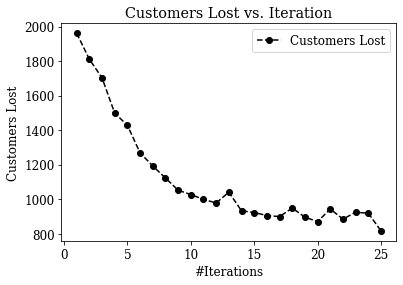

In [ ]:
# Plot loss vs. Iterations
plt.plot(np.arange(1, 26), Outputs_cust_lost["cust_lost_losses"], label="Customers Lost", linestyle="--", marker="o", color="black")
plt.title("Customers Lost vs. Iteration")
plt.ylabel("Customers Lost")
plt.xlabel("#Iterations")
plt.legend(loc="best")
plt.show()

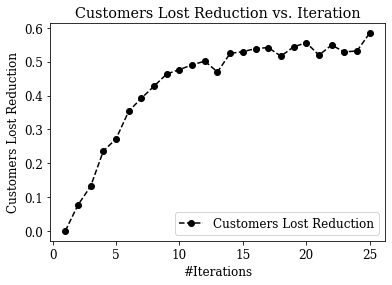

In [ ]:
# Plot loss vs. Iterations
plt.plot(np.arange(1, 26), Outputs_cust_lost["cust_lost_loss_reducts"], label="Customers Lost Reduction", linestyle="--", marker="o", color="black")
plt.title("Customers Lost Reduction vs. Iteration")
plt.ylabel("Customers Lost Reduction")
plt.xlabel("#Iterations")
plt.legend(loc="lower right")
plt.show()

### Minimizing Unavailable Docks

In [ ]:
# Perform adaptive learning
Outputs_docks_na = adaptive_learning(learning_rate=1,
                                     n_iter=25, 
                                     n_sim=10,
                                     wt_cust_lost_loss=0.0, 
                                     wt_docks_na_loss=1.0,
                                     n_citibikes=n_citibikes, 
                                     station_capacity=station_capacity, 
                                     lmbda_matrix=lmbda_matrix, 
                                     destination_prob_matrix=destination_prob_matrix, 
                                     geo_dist_matrix=geo_dist_matrix, 
                                     time_matrix=time_matrix,
                                     start_time_bins=start_time_bins)

Iteration: 1/25 [==================] 10/10 Simulations complete. Time:  0:18:16
Expected Value of Customers Lost = 2025.00
Expected Value of Unavailable Docks = 2645.00

Iteration: 2/25 [==================] 10/10 Simulations complete. Time:  0:18:09
Expected Value of Customers Lost = 1988.00 Reduction = 1.83%
Expected Value of Unavailable Docks = 2273.30 Reduction = 14.05%
Weighted Reduction = 14.05%

Iteration: 3/25 [==================] 10/10 Simulations complete. Time:  0:18:07
Expected Value of Customers Lost = 2021.10 Reduction = 0.19%
Expected Value of Unavailable Docks = 2091.40 Reduction = 20.93%
Weighted Reduction = 20.93%

Iteration: 4/25 [==================] 10/10 Simulations complete. Time:  0:18:02
Expected Value of Customers Lost = 2143.50 Reduction = -5.85%
Expected Value of Unavailable Docks = 2003.40 Reduction = 24.26%
Weighted Reduction = 24.26%

Iteration: 5/25 [==================] 10/10 Simulations complete. Time:  0:18:07
Expected Value of Customers Lost = 2119.80 R

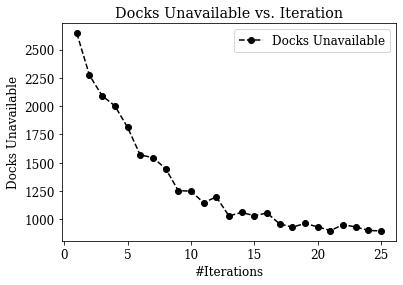

In [ ]:
# Plot loss vs. Iterations
plt.plot(np.arange(1, 26), Outputs_docks_na["docks_na_losses"], label="Docks Unavailable", linestyle="--", marker="o", color="black")
plt.title("Docks Unavailable vs. Iteration")
plt.ylabel("Docks Unavailable")
plt.xlabel("#Iterations")
plt.legend(loc="best")
plt.show()

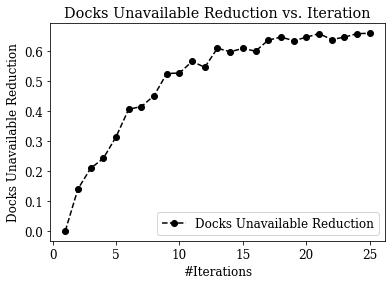

In [ ]:
# Plot loss vs. Iterations
plt.plot(np.arange(1, 26), Outputs_docks_na["docks_na_loss_reducts"], label="Docks Unavailable Reduction", linestyle="--", marker="o", color="black")
plt.title("Docks Unavailable Reduction vs. Iteration")
plt.ylabel("Docks Unavailable Reduction")
plt.xlabel("#Iterations")
plt.legend(loc="lower right")
plt.show()

### Minimizing Both Customers Lost and Unavailable Docks

#### Equal Weights

In [ ]:
# Perform adaptive learning
Outputs_eq = adaptive_learning(learning_rate=1,
                               n_iter=25,
                               n_sim=10,
                               wt_cust_lost_loss=0.5,
                               wt_docks_na_loss=0.5,
                               n_citibikes=n_citibikes,
                               station_capacity=station_capacity,
                               lmbda_matrix=lmbda_matrix,
                               destination_prob_matrix=destination_prob_matrix,
                               geo_dist_matrix=geo_dist_matrix, 
                               time_matrix=time_matrix,
                               start_time_bins=start_time_bins)

Iteration: 1/25 [==================] 10/10 Simulations complete. Time:  0:18:42
Expected Value of Customers Lost = 1990.10
Expected Value of Unavailable Docks = 2593.20

Iteration: 2/25 [==================] 10/10 Simulations complete. Time:  0:18:40
Expected Value of Customers Lost = 1904.10 Reduction = 4.32%
Expected Value of Unavailable Docks = 2385.90 Reduction = 7.99%
Weighted Reduction = 6.16%

Iteration: 3/25 [==================] 10/10 Simulations complete. Time:  0:18:41
Expected Value of Customers Lost = 1799.00 Reduction = 9.60%
Expected Value of Unavailable Docks = 2213.20 Reduction = 14.65%
Weighted Reduction = 12.13%

Iteration: 4/25 [==================] 10/10 Simulations complete. Time:  0:18:41
Expected Value of Customers Lost = 1691.00 Reduction = 15.03%
Expected Value of Unavailable Docks = 2157.40 Reduction = 16.81%
Weighted Reduction = 15.92%

Iteration: 5/25 [==================] 10/10 Simulations complete. Time:  0:18:47
Expected Value of Customers Lost = 1644.00 Red

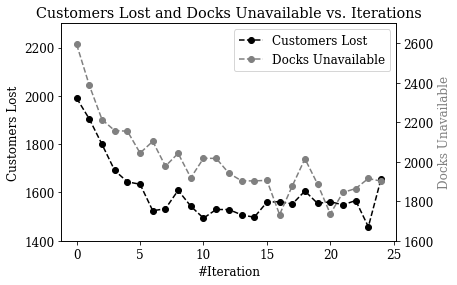

In [ ]:
# Create plot for loss
x = np.arange(25)
y1 = Outputs_eq["cust_lost_losses"]
y2 = Outputs_eq["docks_na_losses"]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
l1 = ax1.plot(x, y1, label="Customers Lost", linestyle="--", marker="o", color="black")
l2 = ax2.plot(x, y2, label="Docks Unavailable", linestyle="--", marker="o", color="grey")

lns = l1 + l2
labs = [l.get_label() for l in lns]

ax1.set_xlabel('#Iteration')
ax1.legend(lns, labs, loc=0)
ax1.set_ylabel('Customers Lost', color="black")
ax2.set_ylabel('Docks Unavailable', color="grey")
ax1.set_ylim(1400, 2300)
ax2.set_ylim(1600, 2700)
ax1.set_yticks(np.arange(1400, 2300, 200))
ax2.set_yticks(np.arange(1600, 2700, 200))
plt.title("Customers Lost and Docks Unavailable vs. Iterations")
plt.show()

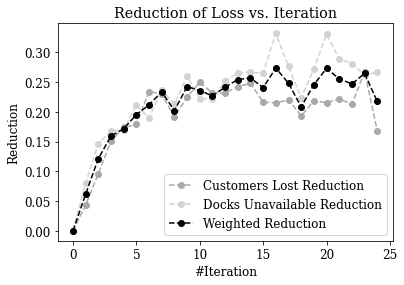

In [ ]:
# Plot customers lost vs. iteration
plt.plot(np.arange(25), Outputs_eq["cust_lost_loss_reducts"], label="Customers Lost Reduction", linestyle="--", marker="o", color="darkgrey")
plt.plot(np.arange(25), Outputs_eq["docks_na_loss_reducts"], label="Docks Unavailable Reduction", linestyle="--", marker="o", color="lightgrey")
plt.plot(np.arange(25), Outputs_eq["weighted_reducts"], label="Weighted Reduction", linestyle="--", marker="o", color="black")
plt.title("Reduction of Loss vs. Iteration")
plt.xlabel("#Iteration")
plt.ylabel("Reduction")
plt.legend(loc='best')
plt.show()

#### Unequal Weights

In [ ]:
# Perform adaptive learning
Outputs_uneq = adaptive_learning(learning_rate=1,
                                 n_iter=25,
                                 n_sim=10,
                                 wt_cust_lost_loss=0.75,
                                 wt_docks_na_loss=0.25,
                                 n_citibikes=n_citibikes,
                                 station_capacity=station_capacity,
                                 lmbda_matrix=lmbda_matrix,
                                 destination_prob_matrix=destination_prob_matrix,
                                 geo_dist_matrix=geo_dist_matrix,
                                 time_matrix=time_matrix,
                                 start_time_bins=start_time_bins)

Iteration: 1/25 [==================] 10/10 Simulations complete. Time:  0:19:18
Expected Value of Customers Lost = 1952.80
Expected Value of Unavailable Docks = 2604.70

Iteration: 2/25 [==================] 10/10 Simulations complete. Time:  0:19:24
Expected Value of Customers Lost = 1912.40 Reduction = 2.07%
Expected Value of Unavailable Docks = 2460.70 Reduction = 5.53%
Weighted Reduction = 2.93%

Iteration: 3/25 [==================] 10/10 Simulations complete. Time:  0:19:39
Expected Value of Customers Lost = 1758.80 Reduction = 9.93%
Expected Value of Unavailable Docks = 2399.50 Reduction = 7.88%
Weighted Reduction = 9.42%

Iteration: 4/25 [==================] 10/10 Simulations complete. Time:  0:19:32
Expected Value of Customers Lost = 1702.20 Reduction = 12.83%
Expected Value of Unavailable Docks = 2289.80 Reduction = 12.09%
Weighted Reduction = 12.65%

Iteration: 5/25 [==================] 10/10 Simulations complete. Time:  0:19:45
Expected Value of Customers Lost = 1690.80 Reduc

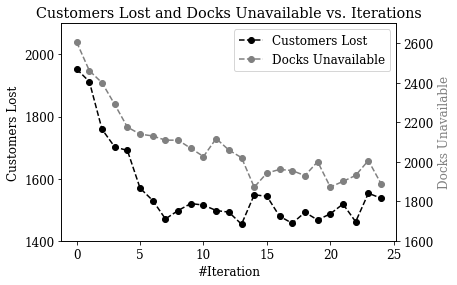

In [ ]:
# Create plot for loss
x = np.arange(25)
y1 = Outputs_uneq["cust_lost_losses"]
y2 = Outputs_uneq["docks_na_losses"]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
l1 = ax1.plot(x, y1, label="Customers Lost", linestyle="--", marker="o", color="black")
l2 = ax2.plot(x, y2, label="Docks Unavailable", linestyle="--", marker="o", color="grey")

lns = l1 + l2
labs = [l.get_label() for l in lns]

ax1.set_xlabel('#Iteration')
ax1.legend(lns, labs, loc=0)
ax1.set_ylabel('Customers Lost', color="black")
ax2.set_ylabel('Docks Unavailable', color="grey")
ax1.set_ylim(1400, 2100)
ax2.set_ylim(1600, 2700)
ax1.set_yticks(np.arange(1400, 2100, 200))
ax2.set_yticks(np.arange(1600, 2700, 200))
plt.title("Customers Lost and Docks Unavailable vs. Iterations")
plt.show()

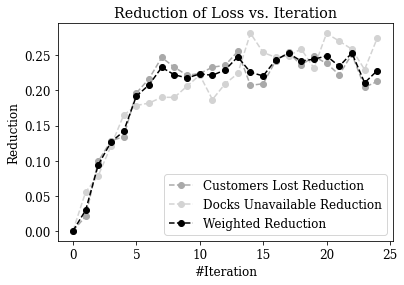

In [ ]:
# Plot customers lost vs. iteration
plt.plot(np.arange(25), Outputs_uneq["cust_lost_loss_reducts"], label="Customers Lost Reduction", linestyle="--", marker="o", color="darkgrey")
plt.plot(np.arange(25), Outputs_uneq["docks_na_loss_reducts"], label="Docks Unavailable Reduction", linestyle="--", marker="o", color="lightgrey")
plt.plot(np.arange(25), Outputs_uneq["weighted_reducts"], label="Weighted Reduction", linestyle="--", marker="o", color="black")
plt.title("Reduction of Loss vs. Iteration")
plt.xlabel("#Iteration")
plt.ylabel("Reduction")
plt.legend(loc='best')
plt.show()

### Store/Load Models

In [ ]:
# Store files
with open('Outputs_cust_lost.pkl', 'wb') as f:
  pickle.dump(Outputs_cust_lost, f)
with open('Outputs_docks_na.pkl', 'wb') as f:
  pickle.dump(Outputs_docks_na, f)
with open('Outputs_eq.pkl', 'wb') as f:
  pickle.dump(Outputs_eq, f)
with open('Outputs_uneq.pkl', 'wb') as f:
  pickle.dump(Outputs_uneq, f)

In [ ]:
# Download files
files.download('Outputs_cust_lost.pkl')
files.download('Outputs_docks_na.pkl')
files.download('Outputs_eq.pkl')
files.download('Outputs_uneq.pkl')

In [ ]:
# Load files
with open('Outputs_cust_lost.pkl', 'rb') as f:
  Outputs_cust_lost = pickle.load(f)
with open('Outputs_docks_na.pkl', 'rb') as f:
  Outputs_docks_na = pickle.load(f)
with open('Outputs_eq.pkl', 'rb') as f:
  Outputs_eq = pickle.load(f)
with open('Outputs_uneq.pkl', 'rb') as f:
  Outputs_uneq = pickle.load(f)

## Business Strategies Analysis

In [ ]:
# Get the most filled and least filled stations in optimal configuration
best_morning_conf = Outputs_cust_lost["best_config"].copy()
best_morning_conf["station_proportion"] = best_morning_conf["bikes_available"] / best_morning_conf["total_docks"]
best_morning_conf = best_morning_conf.sort_values(by="station_proportion", ascending=False)
station_id_name = trips_data[["start station id", "start station name"]].drop_duplicates().set_index("start station id")
best_morning_conf = best_morning_conf.join(station_id_name).dropna()

In [ ]:
best_morning_conf.head(10)

,total_docks,bikes_available,station_proportion,start station name
stationid,,,,
4151,3,3,1.0,3 Ave & E 169 St
346,27,27,1.0,Bank St & Hudson St
536,28,28,1.0,1 Ave & E 30 St
532,43,43,1.0,S 5 Pl & S 5 St
340,27,27,1.0,Madison St & Clinton St
341,19,19,1.0,Stanton St & Mangin St
3814,23,23,1.0,E 56 St & Madison Ave
344,23,23,1.0,Monroe St & Bedford Ave
530,24,24,1.0,11 Ave & W 59 St


In [ ]:
best_morning_conf.tail(10)

,total_docks,bikes_available,station_proportion,start station name
stationid,,,,
4160,19,0,0.0,Washington Ave & E 174 St
4157,19,0,0.0,Boston Rd & Prospect Ave
4152,21,0,0.0,Fulton Ave & E 168 St
4149,20,0,0.0,E 167 St & Franklin Ave
4144,22,0,0.0,Lafayette Ave & Hunts Point Ave
4143,21,0,0.0,Hunts Point Ave & Bryant Ave
4142,19,0,0.0,Barry St & Tiffany St
4140,24,0,0.0,E 163 St & Union Ave
4127,19,0,0.0,Ogden Ave & Merriam Ave


## Cost Analysis

### Load Optimal Configuration

In [ ]:
# Save a copy of best configuration
best_morning_conf = Outputs_cust_lost["best_config"].copy()

### Determine EOD configuration for Optimal Configuration

In [ ]:
# Run Simulation to find the mean end configuration for the best morning configuration
EOD_best_morning_conf_sum =  pd.Series(0, index=best_morning_conf.index)

# Run the simulation 10 times
n_sim = 10
for i in range(n_sim):
  bike_init_conf = best_morning_conf.copy()
  cust_arrivals, cust_lost, docks_na, bike_end_conf = citibike_system_simulation(bike_init_conf,
                                                                                lmbda_matrix,
                                                                                destination_prob_matrix,
                                                                                geo_dist_matrix,
                                                                                time_matrix,
                                                                                verbose=False,
                                                                                display_bikes=False)
  # Create sum of EOD configuration
  EOD_best_morning_conf_sum = EOD_best_morning_conf_sum + bike_end_conf["bikes_available"]

# Create mean of EOD configuration
EOD_best_morning_conf = (EOD_best_morning_conf_sum / n_sim).round().astype("int")

### Analyze transfer decisions

In [ ]:
# Assumptions:
# - A revenue of $3 generate for every recovery of lost customer
# - It costs $20 to book a truck for moving bikes between 2 stations
# - Each truck has a capacity of 15 bikes

# Parameters
cust_cost = 3
truck_cost = 20
truck_capacity = 15

# Create difference of optimal morning configuration and corresponding end configuration
transfers = best_morning_conf.copy()
transfers["bikes_available_end"] = EOD_best_morning_conf
transfers.columns = ["total_docks", "bikes_available_best", "bikes_available_end"]
transfers["n_bikes_increase"] = (transfers["bikes_available_best"] - transfers["bikes_available_end"]) * (transfers["bikes_available_best"] > transfers["bikes_available_end"]).astype("bool")

# Number of trucks required for transfering bikes and their cost
transfers["n_trucks"] = transfers["n_bikes_increase"] // truck_capacity + (transfers["n_bikes_increase"] % truck_capacity).astype("bool")
transfers["truck_cost"] = transfers["n_trucks"] * truck_cost

# Cost recovered
transfers["cost_recovered"] = transfers["n_bikes_increase"] * cust_cost

# Make a decision whether to transfer bikes to this station or not based on whether profit is positive by moving the bikes
transfers["transfer_decision"] = (transfers["cost_recovered"] > transfers["truck_cost"]).astype("int")
transfers["profit"] = (transfers["cost_recovered"] - transfers["truck_cost"]) * transfers["transfer_decision"]

# Examples
transfers.loc[[223, 82, 83, 173], :]

,total_docks,bikes_available_best,bikes_available_end,n_bikes_increase,n_trucks,truck_cost,cost_recovered,transfer_decision,profit
stationid,,,,,,,,,
223,33,33,19,14,1,20,42,1,22
82,27,18,13,5,1,20,15,0,0
83,62,35,36,0,0,0,0,0,0
173,70,42,17,25,2,40,75,1,35


### Total Profit Earned Per Day

In [ ]:
# Total increase in profit per day
transfers["profit"].sum()

2158

### Store/Load Transfers

In [ ]:
# Store transfers file
transfers.to_pickle("transfers.pkl")

In [ ]:
# Load transfers file
transfers = pd.read_pickle("transfers.pkl")

## Debugging: Create dummy exercise for POC

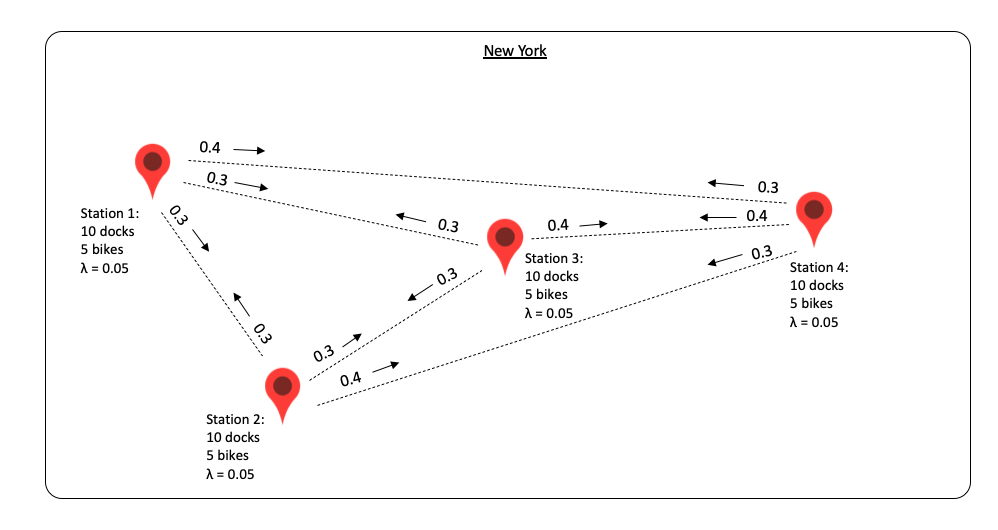

In [ ]:
# # Start time bins
# start_time_bins = ["12:00am - 2:59am",
#                    "3:00am - 5:59am",
#                    "6:00am - 8:59am",
#                    "9:00am - 11:59am",
#                    "12:00pm - 2:59pm",
#                    "3:00pm - 5:59pm",
#                    "6:00pm - 8:59pm",
#                    "9:00pm - 11:59pm"]

In [ ]:
# destination_prob_s = pd.DataFrame({"start station id": [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]*8,	
#                                  "start time bin": sorted(start_time_bins*16),
#                                  "end station id": [1,2,3,4]*4*8,	
#                                  "station_id_destination_prob": [0.0, 0.3, 0.3, 0.4, 0.3, 0.0, 0.3, 0.4, 0.3, 0.3, 0.0, 0.4, 0.3, 0.3, 0.4, 0.0]*8})

# # Create matrix
# destination_prob_matrix_s = destination_prob_s.pivot(index=["start station id", "start time bin"], columns="end station id", values="station_id_destination_prob")
# destination_prob_matrix_s

In [ ]:
# avg_time_matrix_s = pd.DataFrame(index=[1, 2, 3, 4], columns=[1, 2, 3, 4])
# avg_time_matrix_s.index.name = "start_station_id"
# avg_time_matrix_s.loc[1, :] = [0, 1600, 1500, 1200]
# avg_time_matrix_s.loc[2, :] = [2100, 0, 1150, 1450]
# avg_time_matrix_s.loc[3, :] = [1500, 2250, 0, 2335]
# avg_time_matrix_s.loc[4, :] = [2345, 1545, 1425, 0]
# avg_time_matrix_s

In [ ]:
# lmbda_matrix_s = pd.DataFrame(index=[1, 2, 3, 4], columns=start_time_bins)
# lmbda_matrix_s.loc[1, :] = [0,	0, 0,	0, 0, 0, 0, 0]
# lmbda_matrix_s.loc[2, :] = [0.001773206,	0.001543675, 0.001697425,	0.001161790, 0.00158446, 0.00220567, 0.00173627, 0.000849029]
# lmbda_matrix_s.loc[3, :] = [0.000595542,	0.001889170, 0.000502801,	0.000705699, 0.00107152, 0.00123861, 0.00109040, 0.000465655]
# lmbda_matrix_s.loc[4, :] = [0.000754852,	0.000477977, 0.002462500,	0.002410770, 0.00365010, 0.00411505, 0.00366428, 0.001357870]

In [ ]:
# lmbda_matrix_s.head()

In [ ]:
# # 1. Home
# # W 107 St & Columbus Ave, New York, NY 10025
# # 40.799758, -73.962112

# # 2. Times square
# # 723 8th Ave
# # New York, NY 10036
# # 40.759379, -73.988582

# # 3. Columbia
# # 605 W 116th St
# # New York, NY 10027
# # 40.808387, -73.964111

# # 4. Central Park
# # Bridle Path
# # New York, NY 10024
# # 40.779289, -73.973506

# station_lat_lon_s = pd.DataFrame({"station id": [1,2,3,4],
#                                 "lat": [40.799758, 40.759379, 40.808387, 40.779289],
#                                 "lon": [-73.962112, -73.988582, -73.964111, -73.973506]})
# station_lat_lon_s = station_lat_lon_s.set_index("station id")
# station_lat_lon_s

In [ ]:
# geo_dist_matrix_s = create_geo_dist_matrix(station_lat_lon_s)
# geo_dist_matrix_s

In [ ]:
# n_citibikes_s = 25
# station_capacity_s = pd.Series({1: 10, 2: 15, 3: 10, 4: 12})
# station_capacity_s

In [ ]:
# # Create resources (bikes)
# bike_init_conf_s = create_bikes_eq_prop(n_citibikes_s, station_capacity_s, False, False)

In [ ]:
# from IPython.display import clear_output
# import time

In [ ]:
# def plot_loss_reductions():
#   # Plot loss vs. Iterations
#   for i in range(26):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.5))

#     axes[0].plot(np.arange(1, i+1), Outputs_cust_lost["cust_lost_losses"][:i], label="Customers Lost", linestyle="--", marker="o", color="black")
#     axes[0].set_title("Customers Lost vs. Iteration")
#     axes[0].set_ylabel("Customers Lost")
#     axes[0].set_xlabel("#Iterations")
#     axes[0].set_xlim(0, 26)
#     axes[0].set_ylim(780, 2100)

#     # Plot loss vs. Iterations
#     axes[1].plot(np.arange(1, i+1), Outputs_cust_lost["cust_lost_loss_reducts"][:i], label="Customers Lost Reduction", linestyle="--", marker="o", color="black")
#     axes[1].set_title("Customers Lost Reduction vs. Iteration")
#     axes[1].set_ylabel("Customers Lost Reduction")
#     axes[1].set_xlabel("#Iterations")
#     axes[1].set_xlim(0, 26)
#     axes[1].set_ylim(-0.05, 0.62)

#     fig.tight_layout()
#     plt.show()

#     time.sleep(0.25)
#     clear_output(wait=True)

In [ ]:
# # Load files
# with open('Outputs_cust_lost.pkl', 'rb') as f:
#   Outputs_cust_lost = pickle.load(f)

In [ ]:
# # Run Simulation
# Outputs_s, cust_arrivals_s, cust_lost_s, bike_end_conf_s = citibike_system_simulation(bike_init_conf_s,
#                                                                                       lmbda_matrix_s,
#                                                                                       destination_prob_matrix_s,
#                                                                                       geo_dist_matrix_s,
#                                                                                       avg_time_matrix_s,
#                                                                                       verbose=False,
#                                                                                       display_bikes=False)

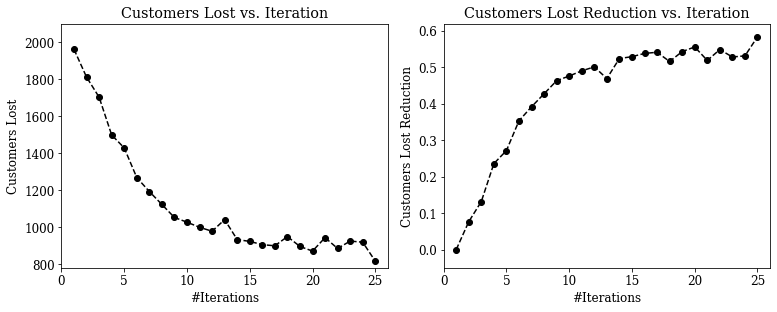

In [ ]:
# plot_loss_reductions()